# Dynamic Model System Design

The goal is to design a dynamic model that can predict the RNA yield from the pH
measurements and can recalibrate its predictions using estimates for purified RNA
yield coming from the purification step.

<div style="text-align: center;">
  <img src="../../assets/mpc.png" alt="MPC Architecture" width="600"/>
</div>


## Assume a perfect UKF

Testing a simple hypothesis, if reupdating the parameters of the model should suffice
to approach the system dynamics, then the model should be able to predict the RNA
yield of the IVT reaction perfectly.

<div style="text-align: center;">
  <img src="../../assets/state_estimation.png" alt="UKF Architecture" width="600"/>
</div>


Key Enhanced Green Fluorescent Protein not found in the registry.
Returning default values: {'k_app': 5000.0, 'k1': 0.786, 'k2': 60400000.0} for keys: ['Enhanced Green Fluorescent Protein', 'lhs']


<Axes: >

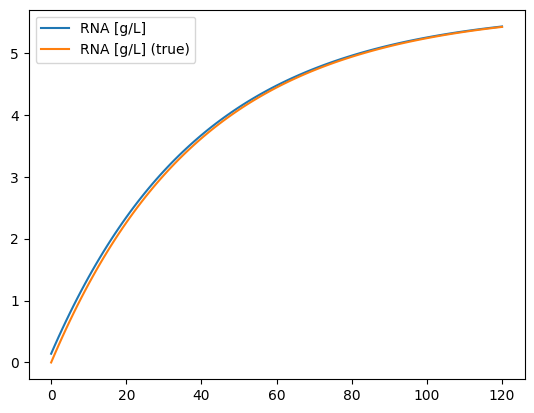

In [55]:
import r3.models.assimulo.assimulo_model as ivt_model
import r3.schema as schema
import pandas as pd

model = ivt_model.AssimuloIVTModel()
t, y, true_system_dynamics = model.simulate(t_final=120, ncp=120, get_full_state=True)


def predict_rna_yield(
    experimental_conditions: pd.DataFrame,
) -> pd.DataFrame:
    """NOTE: ensure if you pass NTPs are divided by 4"""
    predictions = []
    previous_state: dict[str, float] = dict()
    for _, row in experimental_conditions.iterrows():

        _, _, result = model.simulate(
            RNA_init=row.get(
                schema.IVTReactionSchema.RNA_M.value,
                previous_state.get(schema.IVTReactionSchema.RNA_M.value, None),
            ),
            ATP_init=row.get(
                schema.IVTReactionSchema.ATP_M.value,
                previous_state.get(schema.IVTReactionSchema.ATP_M.value, None),
            ),
            CTP_init=row.get(
                schema.IVTReactionSchema.CTP_M.value,
                previous_state.get(schema.IVTReactionSchema.CTP_M.value, None),
            ),
            GTP_init=row.get(
                schema.IVTReactionSchema.GTP_M.value,
                previous_state.get(schema.IVTReactionSchema.GTP_M.value, None),
            ),
            UTP_init=row.get(
                schema.IVTReactionSchema.UTP_M.value,
                previous_state.get(schema.IVTReactionSchema.UTP_M.value, None),
            ),
            NTP_init=row.get(
                schema.IVTReactionSchema.NTP_M.value,
                previous_state.get(schema.IVTReactionSchema.NTP_M.value, None),
            ),
            PPi_init=row.get(
                schema.IVTReactionSchema.PPi_M.value,
                previous_state.get(schema.IVTReactionSchema.PPi_M.value, None),
            ),
            Mgtot_init=row.get(
                schema.IVTReactionSchema.Mg2_M.value,
                previous_state.get(schema.IVTReactionSchema.Mg2_M.value, None),
            ),
            DNA_init=row.get(
                schema.IVTReactionSchema.DNA_ug_mL.value,
                previous_state.get(schema.IVTReactionSchema.DNA_ug_mL.value, None),
            ),
            T7tot_init=row.get(
                schema.IVTReactionSchema.T7RNAP_u_uL.value,
                previous_state.get(schema.IVTReactionSchema.T7RNAP_u_uL.value, None),
            ),
            pH=row.get(
                schema.IVTReactionSchema.pH.value,
                previous_state.get(schema.IVTReactionSchema.pH.value, None),
            ),
            t_final=1,
            ncp=1,
            verbose=False,
            get_full_state=True,
        )

        # Commenting out this line as it will invalidate the experiment.
        # previous_state = result.iloc[-1].to_dict()

        predictions.append(result[schema.IVTReactionSchema.RNA_g_L.value].values[-1])

    return pd.DataFrame(predictions, columns=[schema.IVTReactionSchema.RNA_g_L.value])


df = predict_rna_yield(true_system_dynamics)
df[schema.IVTReactionSchema.RNA_g_L.value + " (true)"] = true_system_dynamics[
    schema.IVTReactionSchema.RNA_g_L.value
]

df.plot()

## Relaxing the assumption, what if we can't estimate RNA?
What happens if the UKF is not perfect?


<Axes: >

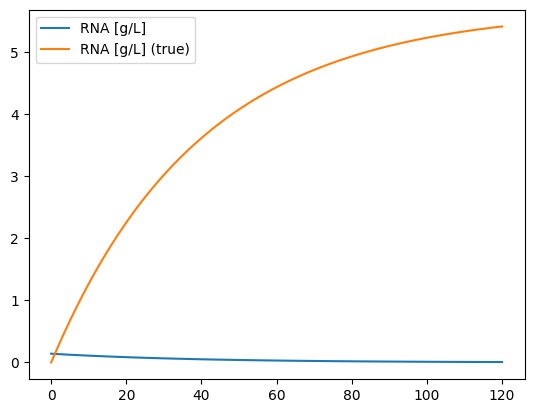

In [56]:
true_system_dynamics_no_rna = true_system_dynamics.drop(
    columns=[
        schema.IVTReactionSchema.RNA_M.value,
        # schema.IVTReactionSchema.PPi_M.value,
        # schema.IVTReactionSchema.Pi_M.value,
        # schema.IVTReactionSchema.ATP_M.value,
        # schema.IVTReactionSchema.CTP_M.value,
        # schema.IVTReactionSchema.UTP_M.value,
        # schema.IVTReactionSchema.GTP_M.value,
        # schema.IVTReactionSchema.Mg2_M.value,
        # schema.IVTReactionSchema.DNA_ug_mL.value,
        # schema.IVTReactionSchema.T7RNAP_u_uL.value,
        # schema.IVTReactionSchema.pH.value,
    ]
)


df = predict_rna_yield(true_system_dynamics_no_rna)
df[schema.IVTReactionSchema.RNA_g_L.value + " (true)"] = true_system_dynamics[
    schema.IVTReactionSchema.RNA_g_L.value
]
bad_assimulo_predictions = df[schema.IVTReactionSchema.RNA_g_L.value].values
df.plot()

If you change the way you predict (instead of propagating you align time steps)


<Axes: >

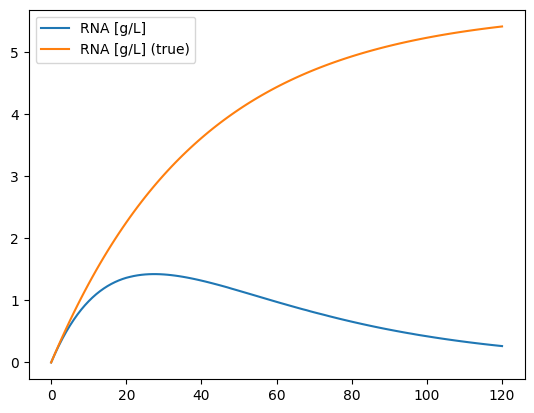

In [57]:
df = model.predict_rna_yield(true_system_dynamics_no_rna, verbose=False)
df[schema.IVTReactionSchema.RNA_g_L.value + " (true)"] = true_system_dynamics[
    schema.IVTReactionSchema.RNA_g_L.value
]

df.plot()

## The Case for a Discrepancy Model

<div style="text-align: center;">
  <img src="../../assets/discrepancy_model.png" alt="Discrepancy Model Architecture" width="600"/>
</div>

Can we adjust the model to account for discrepancies in the predictions?

Mean residual: -3.8495 g/L


<Axes: >

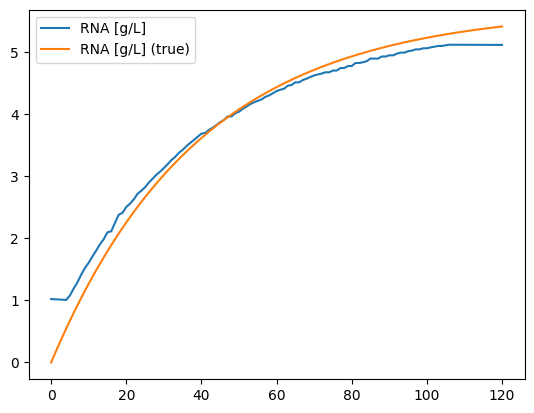

In [60]:
import xgboost as xgb
import numpy as np

X_true = true_system_dynamics.drop(
    columns=[
        schema.IVTReactionSchema.RNA_g_L.value,
        schema.IVTReactionSchema.PPi_M.value,
        schema.IVTReactionSchema.Pi_M.value,
        schema.IVTReactionSchema.ATP_M.value,
        schema.IVTReactionSchema.CTP_M.value,
        schema.IVTReactionSchema.UTP_M.value,
        schema.IVTReactionSchema.GTP_M.value,
        schema.IVTReactionSchema.Mg2_M.value,
        schema.IVTReactionSchema.DNA_ug_mL.value,
        schema.IVTReactionSchema.T7RNAP_u_uL.value,
        schema.IVTReactionSchema.pH.value,
    ]
)
y_true = true_system_dynamics[schema.IVTReactionSchema.RNA_g_L.value].values

residuals = np.array(bad_assimulo_predictions) - y_true
print(f"Mean residual: {np.mean(residuals):.4f} g/L")

# Learn the residuals with xgboost
xgboost_model = xgb.XGBRegressor(
    n_estimators=20,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
)
xgboost_model.fit(X_true.values, residuals)

discrepancy_model_predictions = np.array(
    bad_assimulo_predictions
) - xgboost_model.predict(X_true.values)

df = pd.DataFrame(
    discrepancy_model_predictions,
    columns=[schema.IVTReactionSchema.RNA_g_L.value],
)
df[schema.IVTReactionSchema.RNA_g_L.value + " (true)"] = y_true

df.plot()

## Soft sensors?

<div style="text-align: center;">
  <img src="../../assets/soft_sensor.png" alt="Soft Sensor Architecture" width="600"/>
</div>

In practice getting a perfect UKF is not possible, and its performance is highly dependent on parameters (epsilon) [UKF Parameter Configurations](https://github.com/kesler20/phd_notebooks/blob/master/2025/07/UKF%20for%20dynamic%20modelling.ipynb)

Soft sensors are easier to implement and deploy, debug and calibrate.

<Axes: >

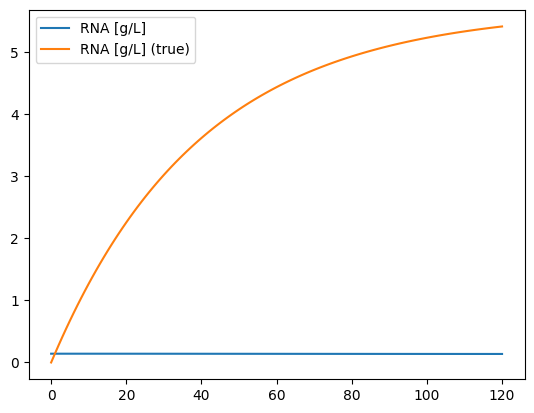

In [63]:
true_system_dynamics_only_ntp = true_system_dynamics.drop(
    columns=[
        schema.IVTReactionSchema.RNA_M.value,
        schema.IVTReactionSchema.PPi_M.value,
        schema.IVTReactionSchema.Pi_M.value,
        # schema.IVTReactionSchema.ATP_M.value,
        # schema.IVTReactionSchema.CTP_M.value,
        # schema.IVTReactionSchema.UTP_M.value,
        # schema.IVTReactionSchema.GTP_M.value,
        schema.IVTReactionSchema.Mg2_M.value,
        schema.IVTReactionSchema.DNA_ug_mL.value,
        schema.IVTReactionSchema.T7RNAP_u_uL.value,
        schema.IVTReactionSchema.pH.value,
    ]
)


df = predict_rna_yield(true_system_dynamics_only_ntp)
df[schema.IVTReactionSchema.RNA_g_L.value + " (true)"] = true_system_dynamics[
    schema.IVTReactionSchema.RNA_g_L.value
]
bad_assimulo_predictions = df[schema.IVTReactionSchema.RNA_g_L.value].values
df.plot()

<Axes: >

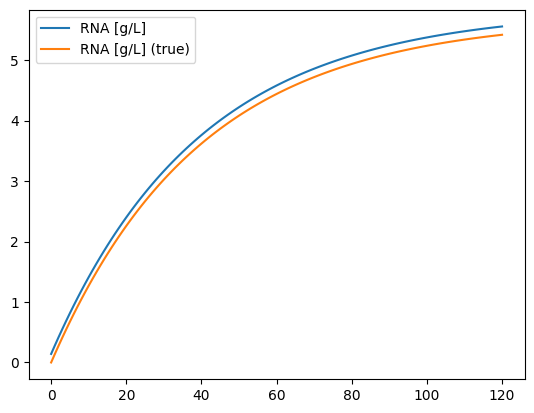

In [64]:
true_system_dynamics_ntp_and_rna = true_system_dynamics.drop(
    columns=[
        # schema.IVTReactionSchema.RNA_M.value,
        schema.IVTReactionSchema.PPi_M.value,
        schema.IVTReactionSchema.Pi_M.value,
        # schema.IVTReactionSchema.ATP_M.value,
        # schema.IVTReactionSchema.CTP_M.value,
        # schema.IVTReactionSchema.UTP_M.value,
        # schema.IVTReactionSchema.GTP_M.value,
        schema.IVTReactionSchema.Mg2_M.value,
        schema.IVTReactionSchema.DNA_ug_mL.value,
        schema.IVTReactionSchema.T7RNAP_u_uL.value,
        schema.IVTReactionSchema.pH.value,
    ]
)


df = predict_rna_yield(true_system_dynamics_ntp_and_rna)
df[schema.IVTReactionSchema.RNA_g_L.value + " (true)"] = true_system_dynamics[
    schema.IVTReactionSchema.RNA_g_L.value
]
bad_assimulo_predictions = df[schema.IVTReactionSchema.RNA_g_L.value].values
df.plot()